In [1]:
#  -*- coding: utf-8 -*-
import math                         # 导入模块
import random                       # 导入模块
import pandas as pd                 # 导入模块 
import numpy as np                  # 导入模块 numpy, 并简写成 np
import matplotlib.pyplot as plt     # 导入模块 matplotlib.pyplot, 并简写成 plt
from datetime import datetime


# 子程序：定义优化问题的目标函数
def cal_Energy(X, nVar):
    # 测试函数 1： Schwefel 测试函数
    # -500 <= Xi <= 500
    # 全局极值：(420.9687,420.9687,...),f(x)=0.0
    sum = 0.0
    for i in range(nVar):
        sum += X[i] * np.sin(np.sqrt(abs(X[i])))
    fx = 418.9829 * nVar - sum
    return fx


# 子程序：模拟退火算法的参数设置
def ParameterSetting():
    cName = "funcOpt"           # 定义问题名称
    nVar = 2                    # 给定自变量数量，y=f(x1,..xn)
    xMin = [-500, -500]         # 给定搜索空间的下限，x1_min,..xn_min
    xMax = [500, 500]           # 给定搜索空间的上限，x1_max,..xn_max

    tInitial = 100.0            # 设定初始退火温度(initial temperature)
    tFinal  = 1                 # 设定终止退火温度(stop temperature)
    alfa    = 0.98              # 设定降温参数，T(k)=alfa*T(k-1)
    meanMarkov = 100            # Markov链长度，也即内循环运行次数
    scale   = 0.5               # 定义搜索步长，可以设为固定值或逐渐缩小
    return cName, nVar, xMin, xMax, tInitial, tFinal, alfa, meanMarkov, scale


# 模拟退火算法
def OptimizationSSA(nVar,xMin,xMax,tInitial,tFinal,alfa,meanMarkov,scale):
    # ====== 初始化随机数发生器 ======
    randseed = random.randint(1, 100)
    random.seed(randseed)  # 随机数发生器设置种子，也可以设为指定整数

    # ====== 随机产生优化问题的初始解 ======
    xInitial = np.zeros((nVar))   # 初始化，创建数组
    for v in range(nVar):
        # random.uniform(min,max) 在 [min,max] 范围内随机生成一个实数
        xInitial[v] = random.uniform(xMin[v], xMax[v])
    # 调用子函数 cal_Energy 计算当前解的目标函数值
    fxInitial = cal_Energy(xInitial, nVar)

    # ====== 模拟退火算法初始化 ======
    xNew = np.zeros((nVar))         # 初始化，创建数组
    xNow = np.zeros((nVar))         # 初始化，创建数组
    xBest = np.zeros((nVar))        # 初始化，创建数组
    xNow[:]  = xInitial[:]          # 初始化当前解，将初始解置为当前解
    xBest[:] = xInitial[:]          # 初始化最优解，将当前解置为最优解
    fxNow  = fxInitial              # 将初始解的目标函数置为当前值
    fxBest = fxInitial              # 将当前解的目标函数置为最优值
    print('x_Initial:{:.6f},{:.6f},\tf(x_Initial):{:.6f}'.format(xInitial[0], xInitial[1], fxInitial))

    recordIter = []                 # 初始化，外循环次数
    recordFxNow = []                # 初始化，当前解的目标函数值
    recordFxBest = []               # 初始化，最佳解的目标函数值
    recordPBad = []                 # 初始化，劣质解的接受概率
    kIter = 0                       # 外循环迭代次数，温度状态数
    totalMar = 0                    # 总计 Markov 链长度
    totalImprove = 0                # fxBest 改善次数
    nMarkov = meanMarkov            # 固定长度 Markov链

    # ====== 开始模拟退火优化 ======
    # 外循环，直到当前温度达到终止温度时结束
    tNow = tInitial                 # 初始化当前温度(current temperature)
    while tNow >= tFinal:           # 外循环，直到当前温度达到终止温度时结束
        # 在当前温度下，进行充分次数(nMarkov)的状态转移以达到热平衡
        kBetter = 0                 # 获得优质解的次数
        kBadAccept = 0              # 接受劣质解的次数
        kBadRefuse = 0              # 拒绝劣质解的次数

        # ---内循环，循环次数为Markov链长度
        for k in range(nMarkov):    # 内循环，循环次数为Markov链长度
            totalMar += 1           # 总 Markov链长度计数器

            # ---产生新解
            # 产生新解：通过在当前解附近随机扰动而产生新解，新解必须在 [min,max] 范围内
            # 方案 1：只对 n元变量中的一个进行扰动，其它 n-1个变量保持不变
            xNew[:] = xNow[:]
            v = random.randint(0, nVar-1)   # 产生 [0,nVar-1]之间的随机数
            xNew[v] = xNow[v] + scale * (xMax[v]-xMin[v]) * random.normalvariate(0, 1)
            # random.normalvariate(0, 1)：产生服从均值为0、标准差为 1 的正态分布随机实数
            xNew[v] = max(min(xNew[v], xMax[v]), xMin[v])  # 保证新解在 [min,max] 范围内

            # ---计算目标函数和能量差
            # 调用子函数 cal_Energy 计算新解的目标函数值
            fxNew = cal_Energy(xNew, nVar)
            deltaE = fxNew - fxNow

            # ---按 Metropolis 准则接受新解
            # 接受判别：按照 Metropolis 准则决定是否接受新解
            if fxNew < fxNow:  # 更优解：如果新解的目标函数好于当前解，则接受新解
                accept = True
                kBetter += 1
            else:  # 容忍解：如果新解的目标函数比当前解差，则以一定概率接受新解
                pAccept = math.exp(-deltaE / tNow)  # 计算容忍解的状态迁移概率
                if pAccept > random.random():
                    accept = True  # 接受劣质解
                    kBadAccept += 1
                else:
                    accept = False  # 拒绝劣质解
                    kBadRefuse += 1

            # 保存新解
            if accept == True:  # 如果接受新解，则将新解保存为当前解
                xNow[:] = xNew[:]
                fxNow = fxNew
                if fxNew < fxBest:  # 如果新解的目标函数好于最优解，则将新解保存为最优解
                    fxBest = fxNew
                    xBest[:] = xNew[:]
                    totalImprove += 1
                    scale = scale*0.99  # 可变搜索步长，逐步减小搜索范围，提高搜索精度
                    
        # ---内循环结束后的数据整理
        # 完成当前温度的搜索，保存数据和输出
        pBadAccept = kBadAccept / (kBadAccept + kBadRefuse)  # 劣质解的接受概率
        recordIter.append(kIter)  # 当前外循环次数
        recordFxNow.append(round(fxNow, 4))  # 当前解的目标函数值
        recordFxBest.append(round(fxBest, 4))  # 最佳解的目标函数值
        recordPBad.append(round(pBadAccept, 4))  # 最佳解的目标函数值

        if kIter%10 == 0:                           # 模运算，商的余数
            print('i:{},t(i):{:.2f}, badAccept:{:.6f}, f(x)_best:{:.6f}'.\
                format(kIter, tNow, pBadAccept, fxBest))

        # 缓慢降温至新的温度，降温曲线：T(k)=alfa*T(k-1)
        tNow = tNow * alfa
        kIter = kIter + 1
        # ====== 结束模拟退火过程 ======

    print('improve:{:d}'.format(totalImprove))
    return kIter,xBest,fxBest,fxNow,recordIter,recordFxNow,recordFxBest,recordPBad

# 结果校验与输出
def ResultOutput(cName,nVar,xBest,fxBest,kIter,recordFxNow,recordFxBest,recordPBad,recordIter):
    # ====== 优化结果校验与输出 ======
    fxCheck = cal_Energy(xBest,nVar)
    if abs(fxBest - fxCheck)>1e-3:   # 检验目标函数
        print("Error 2: Wrong total millage!")
        return
    else:
        print("\nOptimization by simulated annealing algorithm:")
        for i in range(nVar):
            print('\tx[{}] = {:.6f}'.format(i,xBest[i]))
        print('\n\tf(x):{:.6f}'.format(fxBest))

    # ====== 优化结果写入数据文件 ======
    nowTime = datetime.now().strftime('%m%d%H%M')       # '02151456'
    fileName = "..\data\{}_{}.dat".format(cName,nowTime)# 数据文件的地址和文件名
    optRecord = {
        "iter":recordIter,
        "FxNow":recordFxNow,
        "FxBest":recordFxBest,
        "PBad":recordPBad}
    df_Record = pd.DataFrame(optRecord)
    df_Record.to_csv(fileName, index=False, encoding="utf_8_sig")
    with open(fileName, 'a+', encoding="utf_8_sig") as fid:
        fid.write("\nOptimization by simulated annealing algorithm:")
        for i in range(nVar):
            fid.write('\n\tx[{}] = {:.6f}'.format(i,xBest[i]))
        fid.write('\n\tf(x):{:.6f}'.format(fxBest))
    print("写入数据文件: %s 完成。" % fileName)

    # ====== 优化结果图形化输出 ======
    plt.figure(figsize=(6, 4), facecolor='#FFFFFF')     # 创建一个图形窗口
    plt.title('Optimization result: {}'.format(cName))  # 设置图形标题
    plt.xlim((0, kIter))                                # 设置 x轴范围
    plt.xlabel('iter')                                  # 设置 x轴标签
    plt.ylabel('f(x)')                                  # 设置 y轴标签
    plt.plot(recordIter, recordFxNow,'b-', label='FxNow')     # 绘制 FxNow 曲线
    plt.plot(recordIter, recordFxBest, 'r-', label='FxBest')  # 绘制 FxBest 曲线
    # plt.plot(recordIter,recordPBad,'r-',label='pBadAccept')  # 绘制 pBadAccept 曲线
    plt.legend()  # 显示图例
    plt.show()

    return


# 主程序
def main():

    # 参数设置，优化问题参数定义，模拟退火算法参数设置
    [cName, nVar, xMin, xMax, tInitial, tFinal, alfa, meanMarkov, scale] = ParameterSetting()
    # print([nVar, xMin, xMax, tInitial, tFinal, alfa, meanMarkov, scale])

    # 模拟退火算法
    [kIter,xBest,fxBest,fxNow,recordIter,recordFxNow,recordFxBest,recordPBad] \
        = OptimizationSSA(nVar,xMin,xMax,tInitial,tFinal,alfa,meanMarkov,scale)
    # print(kIter, fxNow, fxBest, pBadAccept)

    # 结果校验与输出
    ResultOutput(cName, nVar,xBest,fxBest,kIter,recordFxNow,recordFxBest,recordPBad,recordIter)

if __name__ == '__main__':
    main()



x_Initial:-296.329553,-407.306578,	f(x_Initial):938.028832
i:0,t(i):100.00, badAccept:0.402299, f(x)_best:170.025754
i:10,t(i):81.71, badAccept:0.030928, f(x)_best:4.316776
i:20,t(i):66.76, badAccept:0.163265, f(x)_best:0.437205
i:30,t(i):54.55, badAccept:0.010204, f(x)_best:0.015854
i:40,t(i):44.57, badAccept:0.020408, f(x)_best:0.015854
i:50,t(i):36.42, badAccept:0.030928, f(x)_best:0.015854
i:60,t(i):29.76, badAccept:0.010101, f(x)_best:0.015854
i:70,t(i):24.31, badAccept:0.010101, f(x)_best:0.015854
i:80,t(i):19.86, badAccept:0.010000, f(x)_best:0.015854
i:90,t(i):16.23, badAccept:0.010101, f(x)_best:0.015854
i:100,t(i):13.26, badAccept:0.010101, f(x)_best:0.015854
i:110,t(i):10.84, badAccept:0.010000, f(x)_best:0.015854
i:120,t(i):8.85, badAccept:0.000000, f(x)_best:0.015854
i:130,t(i):7.23, badAccept:0.000000, f(x)_best:0.015854
i:140,t(i):5.91, badAccept:0.000000, f(x)_best:0.015854
i:150,t(i):4.83, badAccept:0.010101, f(x)_best:0.015854
i:160,t(i):3.95, badAccept:0.000000, f(x)

<Figure size 600x400 with 1 Axes>

 &ensp; &emsp; 某厂生产甲乙两种饮料，每百箱甲饮料需用原料6千克、工人10名，获利10万元；每百箱乙饮料需用原料5千克、工人20名，获利9万元。
今工厂共有原料60千克、工人150名，又由于其他条件所限甲饮料产量不超过8百箱。如何安排生产计划，即两种饮料各生产多少使获利最大？
    

x_Initial:3.368357,4.236860,	f(x_Initial):-71.815313
i:0,t(i):100.00, badAccept:0.910448, f(x)_best:-147.500000
i:10,t(i):81.71, badAccept:0.724638, f(x)_best:-101.648530
i:20,t(i):66.76, badAccept:0.695652, f(x)_best:-102.427191
i:30,t(i):54.55, badAccept:0.683544, f(x)_best:-102.427187
i:40,t(i):44.57, badAccept:0.594595, f(x)_best:-102.427184
i:50,t(i):36.42, badAccept:0.656716, f(x)_best:-102.427180
i:60,t(i):29.76, badAccept:0.605634, f(x)_best:-102.427176
i:70,t(i):24.31, badAccept:0.519481, f(x)_best:-102.427172
i:80,t(i):19.86, badAccept:0.580247, f(x)_best:-102.427168
i:90,t(i):16.23, badAccept:0.505618, f(x)_best:-102.427165
i:100,t(i):13.26, badAccept:0.360465, f(x)_best:-102.427161
i:110,t(i):10.84, badAccept:0.505882, f(x)_best:-102.427157
i:120,t(i):8.85, badAccept:0.413043, f(x)_best:-102.427153
i:130,t(i):7.23, badAccept:0.065934, f(x)_best:-102.427149
i:140,t(i):5.91, badAccept:0.129032, f(x)_best:-102.607834
i:150,t(i):4.83, badAccept:0.020202, f(x)_best:-102.607834
i

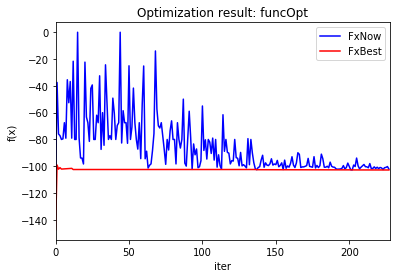

In [7]:
# 模拟退火算法 程序：惩罚函数法求解线性规划问题
#  -*- coding: utf-8 -*-
import math                         
import random                       
import pandas as pd                 
import numpy as np                  # 导入模块 numpy，并简写成 np
import matplotlib.pyplot as plt     
from datetime import datetime

# 子程序：定义优化问题的目标函数
def cal_Energy(X, nVar, mk): 	# m(k)：惩罚因子，随迭代次数 k 逐渐增大
    p1 = (max(0, 6*X[0]+5*X[1]-60))**2
    p2 = (max(0, 10*X[0]+20*X[1]-150))**2
    fx = -(10*X[0]+9*X[1])
    return fx+mk*(p1+p2)


# 子程序：模拟退火算法的参数设置
def ParameterSetting():
    cName = "funcOpt"           # 定义问题名称
    nVar = 2                    # 给定自变量数量，y=f(x1,..xn)
    xMin = [0, 0]               # 给定搜索空间的下限，x1_min,..xn_min
    xMax = [8, 7.5]             # 给定搜索空间的上限，x1_max,..xn_max

    tInitial = 100.0            # 设定初始退火温度(initial temperature)
    tFinal  = 1                 # 设定终止退火温度(stop temperature)
    alfa    = 0.98              # 设定降温参数，T(k)=alfa*T(k-1)
    meanMarkov = 100            # Markov链长度，也即内循环运行次数
    scale   = 0.5               # 定义搜索步长，可以设为固定值或逐渐缩小
    return cName, nVar, xMin, xMax, tInitial, tFinal, alfa, meanMarkov, scale


# 模拟退火算法
def OptimizationSSA(nVar,xMin,xMax,tInitial,tFinal,alfa,meanMarkov,scale):
    # ====== 初始化随机数发生器 ======
    randseed = random.randint(1, 100)
    random.seed(randseed)  # 随机数发生器设置种子，也可以设为指定整数

    # ====== 随机产生优化问题的初始解 ======
    xInitial = np.zeros((nVar))   # 初始化，创建数组
    for v in range(nVar):
        # random.uniform(min,max) 在 [min,max] 范围内随机生成一个实数
        xInitial[v] = random.uniform(xMin[v], xMax[v])
    # 调用子函数 cal_Energy 计算当前解的目标函数值
    fxInitial = cal_Energy(xInitial, nVar, 1) # m(k)：惩罚因子，初值为 1

    # ====== 模拟退火算法初始化 ======
    xNew = np.zeros((nVar))         # 初始化，创建数组
    xNow = np.zeros((nVar))         # 初始化，创建数组
    xBest = np.zeros((nVar))        # 初始化，创建数组
    xNow[:]  = xInitial[:]          # 初始化当前解，将初始解置为当前解
    xBest[:] = xInitial[:]          # 初始化最优解，将当前解置为最优解
    fxNow  = fxInitial              # 将初始解的目标函数置为当前值
    fxBest = fxInitial              # 将当前解的目标函数置为最优值
    print('x_Initial:{:.6f},{:.6f},\tf(x_Initial):{:.6f}'.format(xInitial[0], xInitial[1], fxInitial))

    recordIter = []                 # 初始化，外循环次数
    recordFxNow = []                # 初始化，当前解的目标函数值
    recordFxBest = []               # 初始化，最佳解的目标函数值
    recordPBad = []                 # 初始化，劣质解的接受概率
    kIter = 0                       # 外循环迭代次数，温度状态数
    totalMar = 0                    # 总计 Markov 链长度
    totalImprove = 0                # fxBest 改善次数
    nMarkov = meanMarkov            # 固定长度 Markov链

    # ====== 开始模拟退火优化 ======
    # 外循环，直到当前温度达到终止温度时结束
    tNow = tInitial                 # 初始化当前温度(current temperature)
    while tNow >= tFinal:           # 外循环，直到当前温度达到终止温度时结束
        # 在当前温度下，进行充分次数(nMarkov)的状态转移以达到热平衡
        kBetter = 0                 # 获得优质解的次数
        kBadAccept = 0              # 接受劣质解的次数
        kBadRefuse = 0              # 拒绝劣质解的次数

        # ---内循环，循环次数为Markov链长度
        for k in range(nMarkov):    # 内循环，循环次数为Markov链长度
            totalMar += 1           # 总 Markov链长度计数器

            # ---产生新解
            # 产生新解：通过在当前解附近随机扰动而产生新解，新解必须在 [min,max] 范围内
            # 方案 1：只对 n元变量中的一个进行扰动，其它 n-1个变量保持不变
            xNew[:] = xNow[:]
            v = random.randint(0, nVar-1)   # 产生 [0,nVar-1]之间的随机数
            xNew[v] = xNow[v] + scale * (xMax[v]-xMin[v]) * random.normalvariate(0, 1)
            # random.normalvariate(0, 1)：产生服从均值为0、标准差为 1 的正态分布随机实数
            xNew[v] = max(min(xNew[v], xMax[v]), xMin[v])  # 保证新解在 [min,max] 范围内

            # ---计算目标函数和能量差
            # 调用子函数 cal_Energy 计算新解的目标函数值
            fxNew = cal_Energy(xNew, nVar, kIter)
            deltaE = fxNew - fxNow

            # ---按 Metropolis 准则接受新解
            # 接受判别：按照 Metropolis 准则决定是否接受新解
            if fxNew < fxNow:  # 更优解：如果新解的目标函数好于当前解，则接受新解
                accept = True
                kBetter += 1
            else:  # 容忍解：如果新解的目标函数比当前解差，则以一定概率接受新解
                pAccept = math.exp(-deltaE / tNow)  # 计算容忍解的状态迁移概率
                if pAccept > random.random():
                    accept = True  # 接受劣质解
                    kBadAccept += 1
                else:
                    accept = False  # 拒绝劣质解
                    kBadRefuse += 1

            # 保存新解
            if accept == True:  # 如果接受新解，则将新解保存为当前解
                xNow[:] = xNew[:]
                fxNow = fxNew
                if fxNew < fxBest:  # 如果新解的目标函数好于最优解，则将新解保存为最优解
                    fxBest = fxNew
                    xBest[:] = xNew[:]
                    totalImprove += 1
                    scale = scale*0.99  # 可变搜索步长，逐步减小搜索范围，提高搜索精度
                    
        # ---内循环结束后的数据整理
        # 完成当前温度的搜索，保存数据和输出
        pBadAccept = kBadAccept / (kBadAccept + kBadRefuse)  # 劣质解的接受概率
        recordIter.append(kIter)  # 当前外循环次数
        recordFxNow.append(round(fxNow, 4))  # 当前解的目标函数值
        recordFxBest.append(round(fxBest, 4))  # 最佳解的目标函数值
        recordPBad.append(round(pBadAccept, 4))  # 最佳解的目标函数值

        if kIter%10 == 0:                           # 模运算，商的余数
            print('i:{},t(i):{:.2f}, badAccept:{:.6f}, f(x)_best:{:.6f}'.\
                format(kIter, tNow, pBadAccept, fxBest))

        # 缓慢降温至新的温度，降温曲线：T(k)=alfa*T(k-1)
        tNow = tNow * alfa
        kIter = kIter + 1
        fxBest = cal_Energy(xBest, nVar, kIter)  # 由于迭代后惩罚因子增大，需随之重构增广目标函数
        # ====== 结束模拟退火过程 ======

    print('improve:{:d}'.format(totalImprove))
    return kIter,xBest,fxBest,fxNow,recordIter,recordFxNow,recordFxBest,recordPBad

# 结果校验与输出
def ResultOutput(cName,nVar,xBest,fxBest,kIter,recordFxNow,recordFxBest,recordPBad,recordIter):
    # ====== 优化结果校验与输出 ======
    fxCheck = cal_Energy(xBest, nVar, kIter)
    if abs(fxBest - fxCheck)>1e-3:   # 检验目标函数
        print("Error 2: Wrong total millage!")
        return
    else:
        print("\nOptimization by simulated annealing algorithm:")
        for i in range(nVar):
            print('\tx[{}] = {:.6f}'.format(i,xBest[i]))
        print('\n\tf(x):{:.6f}'.format(cal_Energy(xBest,nVar,0)))

    # ====== 优化结果写入数据文件 ======
    nowTime = datetime.now().strftime('%m%d%H%M')       # '02151456'
    fileName = "..\data\{}_{}.dat".format(cName,nowTime)# 数据文件的地址和文件名
    optRecord = {
        "iter":recordIter,
        "FxNow":recordFxNow,
        "FxBest":recordFxBest,
        "PBad":recordPBad}
    df_Record = pd.DataFrame(optRecord)
    df_Record.to_csv(fileName, index=False, encoding="utf_8_sig")
    with open(fileName, 'a+', encoding="utf_8_sig") as fid:
        fid.write("\nOptimization by simulated annealing algorithm:")
        for i in range(nVar):
            fid.write('\n\tx[{}] = {:.6f}'.format(i,xBest[i]))
        fid.write('\n\tf(x):{:.6f}'.format(cal_Energy(xBest,nVar,0)))
    print("写入数据文件: %s 完成。" % fileName)

    # ====== 优化结果图形化输出 ======
    plt.figure(figsize=(6, 4), facecolor='#FFFFFF')     # 创建一个图形窗口
    plt.title('Optimization result: {}'.format(cName))  # 设置图形标题
    plt.xlim((0, kIter))                                # 设置 x轴范围
    plt.xlabel('iter')                                  # 设置 x轴标签
    plt.ylabel('f(x)')                                  # 设置 y轴标签
    plt.plot(recordIter, recordFxNow,'b-', label='FxNow')     # 绘制 FxNow 曲线
    plt.plot(recordIter, recordFxBest, 'r-', label='FxBest')  # 绘制 FxBest 曲线
    # plt.plot(recordIter,recordPBad,'r-',label='pBadAccept')  # 绘制 pBadAccept 曲线
    plt.legend()  # 显示图例
    plt.show()

    return


# 主程序
def main():

    # 参数设置，优化问题参数定义，模拟退火算法参数设置
    [cName, nVar, xMin, xMax, tInitial, tFinal, alfa, meanMarkov, scale] = ParameterSetting()
    # print([nVar, xMin, xMax, tInitial, tFinal, alfa, meanMarkov, scale])

    # 模拟退火算法
    [kIter,xBest,fxBest,fxNow,recordIter,recordFxNow,recordFxBest,recordPBad] \
        = OptimizationSSA(nVar,xMin,xMax,tInitial,tFinal,alfa,meanMarkov,scale)
    #print(kIter, fxNow, fxBest, pBadAccept)

    # 结果校验与输出
    ResultOutput(cName, nVar,xBest,fxBest,kIter,recordFxNow,recordFxBest,recordPBad,recordIter)

if __name__ == '__main__':
    main()


&emsp;&emsp;某厂生产甲乙两种饮料，每百箱甲饮料需用原料6千克、工人10名，获利10万元；每百箱乙饮料需用原料5千克、工人20名，获利9万元。今工厂共有原料60千克、工人150名，又由于其他条件所限甲饮料产量不超过8百箱。若不允许散箱（按整百箱生产），如何安排生产计划，即两种饮料各生产多少使获利最大？

In [9]:
# 模拟退火算法 程序：求解线性规划问题（整数规划）
#  -*- coding: utf-8 -*-
import math                         
import random                       
import pandas as pd                 
import numpy as np                  # 导入模块 numpy，并简写成 np
import matplotlib.pyplot as plt     
from datetime import datetime

# 子程序：定义优化问题的目标函数
def cal_Energy(X, nVar, mk): 	# m(k)：惩罚因子，随迭代次数 k 逐渐增大
    p1 = (max(0, 6*X[0]+5*X[1]-60))**2
    p2 = (max(0, 10*X[0]+20*X[1]-150))**2
    fx = -(10*X[0]+9*X[1])
    return fx+mk*(p1+p2)


# 子程序：模拟退火算法的参数设置
def ParameterSetting():
    cName = "funcOpt"           # 定义问题名称 
    nVar = 2                    # 给定自变量数量，y=f(x1,..xn)
    xMin = [0, 0]               # 给定搜索空间的下限，x1_min,..xn_min
    xMax = [8, 8]               # 给定搜索空间的上限，x1_max,..xn_max

    tInitial = 100.0            # 设定初始退火温度(initial temperature)
    tFinal  = 1                 # 设定终止退火温度(stop temperature)
    alfa    = 0.98              # 设定降温参数，T(k)=alfa*T(k-1)
    meanMarkov = 100            # Markov链长度，也即内循环运行次数
    scale   = 0.5               # 定义搜索步长，可以设为固定值或逐渐缩小
    return cName, nVar, xMin, xMax, tInitial, tFinal, alfa, meanMarkov, scale


# 模拟退火算法
def OptimizationSSA(nVar,xMin,xMax,tInitial,tFinal,alfa,meanMarkov,scale):
    # ====== 初始化随机数发生器 ======
    randseed = random.randint(1, 100)
    random.seed(randseed)  # 随机数发生器设置种子，也可以设为指定整数

    # ====== 随机产生优化问题的初始解 ======
    xInitial = np.zeros((nVar))   # 初始化，创建数组
    for v in range(nVar):
        # xInitial[v] = random.uniform(xMin[v], xMax[v]) # 产生 [xMin, xMax] 范围的随机实数
        xInitial[v] = random.randint(xMin[v], xMax[v]) # 产生 [xMin, xMax] 范围的随机整数
    # 调用子函数 cal_Energy 计算当前解的目标函数值
    fxInitial = cal_Energy(xInitial, nVar, 1) # m(k)：惩罚因子，初值为 1

    # ====== 模拟退火算法初始化 ======
    xNew = np.zeros((nVar))         # 初始化，创建数组
    xNow = np.zeros((nVar))         # 初始化，创建数组
    xBest = np.zeros((nVar))        # 初始化，创建数组
    xNow[:]  = xInitial[:]          # 初始化当前解，将初始解置为当前解
    xBest[:] = xInitial[:]          # 初始化最优解，将当前解置为最优解
    fxNow  = fxInitial              # 将初始解的目标函数置为当前值
    fxBest = fxInitial              # 将当前解的目标函数置为最优值
    print('x_Initial:{:.6f},{:.6f},\tf(x_Initial):{:.6f}'.format(xInitial[0], xInitial[1], fxInitial))

    recordIter = []                 # 初始化，外循环次数
    recordFxNow = []                # 初始化，当前解的目标函数值
    recordFxBest = []               # 初始化，最佳解的目标函数值
    recordPBad = []                 # 初始化，劣质解的接受概率
    kIter = 0                       # 外循环迭代次数，温度状态数
    totalMar = 0                    # 总计 Markov 链长度
    totalImprove = 0                # fxBest 改善次数
    nMarkov = meanMarkov            # 固定长度 Markov链

    # ====== 开始模拟退火优化 ======
    # 外循环，直到当前温度达到终止温度时结束
    tNow = tInitial                 # 初始化当前温度(current temperature)
    while tNow >= tFinal:           # 外循环，直到当前温度达到终止温度时结束
        # 在当前温度下，进行充分次数(nMarkov)的状态转移以达到热平衡
        kBetter = 0                 # 获得优质解的次数
        kBadAccept = 0              # 接受劣质解的次数
        kBadRefuse = 0              # 拒绝劣质解的次数

        # ---内循环，循环次数为Markov链长度
        for k in range(nMarkov):    # 内循环，循环次数为Markov链长度
            totalMar += 1           # 总 Markov链长度计数器

            # ---产生新解
            # 产生新解：通过在当前解附近随机扰动而产生新解，新解必须在 [min,max] 范围内
            # 方案 1：只对 n元变量中的一个进行扰动，其它 n-1个变量保持不变
            xNew[:] = xNow[:]
            v = random.randint(0, nVar-1)   # 产生 [0,nVar-1]之间的随机数
            xNew[v] = round(xNow[v] + scale * (xMax[v]-xMin[v]) * random.normalvariate(0, 1))
            # 满足决策变量为整数，采用最简单的方案：产生的新解按照四舍五入取整
            xNew[v] = max(min(xNew[v], xMax[v]), xMin[v])  # 保证新解在 [min,max] 范围内

            # ---计算目标函数和能量差
            # 调用子函数 cal_Energy 计算新解的目标函数值
            fxNew = cal_Energy(xNew, nVar, kIter)
            deltaE = fxNew - fxNow

            # ---按 Metropolis 准则接受新解
            # 接受判别：按照 Metropolis 准则决定是否接受新解
            if fxNew < fxNow:  # 更优解：如果新解的目标函数好于当前解，则接受新解
                accept = True
                kBetter += 1
            else:  # 容忍解：如果新解的目标函数比当前解差，则以一定概率接受新解
                pAccept = math.exp(-deltaE / tNow)  # 计算容忍解的状态迁移概率
                if pAccept > random.random():
                    accept = True  # 接受劣质解
                    kBadAccept += 1
                else:
                    accept = False  # 拒绝劣质解
                    kBadRefuse += 1

            # 保存新解
            if accept == True:  # 如果接受新解，则将新解保存为当前解
                xNow[:] = xNew[:]
                fxNow = fxNew
                if fxNew < fxBest:  # 如果新解的目标函数好于最优解，则将新解保存为最优解
                    fxBest = fxNew
                    xBest[:] = xNew[:]
                    totalImprove += 1
                    scale = scale*0.99  # 可变搜索步长，逐步减小搜索范围，提高搜索精度
                    
        # ---内循环结束后的数据整理
        # 完成当前温度的搜索，保存数据和输出
        pBadAccept = kBadAccept / (kBadAccept + kBadRefuse)  # 劣质解的接受概率
        recordIter.append(kIter)  # 当前外循环次数
        recordFxNow.append(round(fxNow, 4))  # 当前解的目标函数值
        recordFxBest.append(round(fxBest, 4))  # 最佳解的目标函数值
        recordPBad.append(round(pBadAccept, 4))  # 最佳解的目标函数值

        if kIter%10 == 0:                           # 模运算，商的余数
            print('i:{},t(i):{:.2f}, badAccept:{:.6f}, f(x)_best:{:.6f}'.\
                format(kIter, tNow, pBadAccept, fxBest))

        # 缓慢降温至新的温度，降温曲线：T(k)=alfa*T(k-1)
        tNow = tNow * alfa
        kIter = kIter + 1
        fxBest = cal_Energy(xBest, nVar, kIter)  # 由于迭代后惩罚因子增大，需随之重构增广目标函数
        # ====== 结束模拟退火过程 ======

    print('improve:{:d}'.format(totalImprove))
    return kIter,xBest,fxBest,fxNow,recordIter,recordFxNow,recordFxBest,recordPBad

# 结果校验与输出
def ResultOutput(cName,nVar,xBest,fxBest,kIter,recordFxNow,recordFxBest,recordPBad,recordIter):
    # ====== 优化结果校验与输出 ======
    fxCheck = cal_Energy(xBest, nVar, kIter)
    if abs(fxBest - fxCheck)>1e-3:   # 检验目标函数
        print("Error 2: Wrong total millage!")
        return
    else:
        print("\nOptimization by simulated annealing algorithm:")
        for i in range(nVar):
            print('\tx[{}] = {:.1f}'.format(i,xBest[i]))
        print('\n\tf(x) = {:.1f}'.format(cal_Energy(xBest,nVar,0)))

    return


# 主程序
def main():

    # 参数设置，优化问题参数定义，模拟退火算法参数设置
    [cName, nVar, xMin, xMax, tInitial, tFinal, alfa, meanMarkov, scale] = ParameterSetting()
    # print([nVar, xMin, xMax, tInitial, tFinal, alfa, meanMarkov, scale])

    # 模拟退火算法    
    [kIter,xBest,fxBest,fxNow,recordIter,recordFxNow,recordFxBest,recordPBad] \
        = OptimizationSSA(nVar,xMin,xMax,tInitial,tFinal,alfa,meanMarkov,scale)
    # print(kIter, fxNow, fxBest, pBadAccept)

    # 结果校验与输出
    ResultOutput(cName, nVar,xBest,fxBest,kIter,recordFxNow,recordFxBest,recordPBad,recordIter)


if __name__ == '__main__':
    main()


x_Initial:1.000000,2.000000,	f(x_Initial):-28.000000
i:0,t(i):100.00, badAccept:0.913043, f(x)_best:-152.000000
i:10,t(i):81.71, badAccept:0.706667, f(x)_best:-98.000000
i:20,t(i):66.76, badAccept:0.558442, f(x)_best:-98.000000
i:30,t(i):54.55, badAccept:0.703704, f(x)_best:-98.000000
i:40,t(i):44.57, badAccept:0.641975, f(x)_best:-98.000000
i:50,t(i):36.42, badAccept:0.693333, f(x)_best:-98.000000
i:60,t(i):29.76, badAccept:0.439024, f(x)_best:-98.000000
i:70,t(i):24.31, badAccept:0.678161, f(x)_best:-98.000000
i:80,t(i):19.86, badAccept:0.301205, f(x)_best:-98.000000
i:90,t(i):16.23, badAccept:0.532609, f(x)_best:-98.000000
i:100,t(i):13.26, badAccept:0.543478, f(x)_best:-98.000000
i:110,t(i):10.84, badAccept:0.310345, f(x)_best:-98.000000
i:120,t(i):8.85, badAccept:0.195652, f(x)_best:-98.000000
i:130,t(i):7.23, badAccept:0.365591, f(x)_best:-98.000000
i:140,t(i):5.91, badAccept:0.147368, f(x)_best:-98.000000
i:150,t(i):4.83, badAccept:0.336735, f(x)_best:-98.000000
i:160,t(i):3.95,

i:0, t(i):100.00, valueNow:18690.0, valueBest:18690.0
i:1, t(i):98.00, valueNow:18209.0, valueBest:18165.0
i:2, t(i):96.04, valueNow:17084.0, valueBest:17084.0
i:3, t(i):94.12, valueNow:17538.0, valueBest:16673.0
i:4, t(i):92.24, valueNow:17629.0, valueBest:16673.0
i:5, t(i):90.39, valueNow:17419.0, valueBest:16673.0
i:6, t(i):88.58, valueNow:16444.0, valueBest:16444.0
i:7, t(i):86.81, valueNow:16022.0, valueBest:16022.0
i:8, t(i):85.08, valueNow:16154.0, valueBest:16022.0
i:9, t(i):83.37, valueNow:16021.0, valueBest:15972.0
i:10, t(i):81.71, valueNow:16074.0, valueBest:15814.0
i:11, t(i):80.07, valueNow:16450.0, valueBest:15814.0
i:12, t(i):78.47, valueNow:15444.0, valueBest:15444.0
i:13, t(i):76.90, valueNow:14780.0, valueBest:14780.0
i:14, t(i):75.36, valueNow:15012.0, valueBest:14780.0
i:15, t(i):73.86, valueNow:15105.0, valueBest:14780.0
i:16, t(i):72.38, valueNow:14606.0, valueBest:14540.0
i:17, t(i):70.93, valueNow:13487.0, valueBest:13487.0
i:18, t(i):69.51, valueNow:13036.0, v

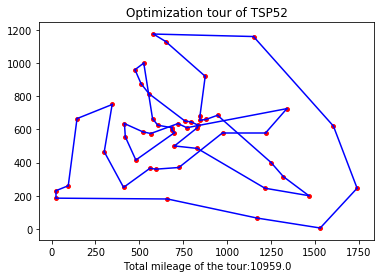

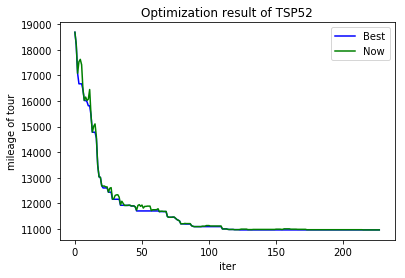

Tour verification successful!
Best tour: 
 [28  1  6 41 16  2 20 29 19 49 15 24 11 50 36 38  0 21 17 30 22 33 34 35
 48 31  7 40 18 44 39 37 23 47 43 45 25 12 26 27  3  5  4 14 42  9  8 32
 10 51 13 46]
Best value: 10959.0


In [10]:
#   模拟退火求解旅行商问题（TSP）基本算法
#  -*- coding: utf-8 -*-
import math                         # 导入模块 math
import random                       # 导入模块 random
import pandas as pd                 # 导入模块 pandas 并简写成 pd
import numpy as np                  # 导入模块 numpy 并简写成 np YouCans
import matplotlib.pyplot as plt     # 导入模块 matplotlib.pyplot 并简写成 plt

np.set_printoptions(precision=4)
pd.set_option('display.max_rows', 20)
pd.set_option('expand_frame_repr', False)
pd.options.display.float_format = '{:,.2f}'.format

# 子程序：初始化模拟退火算法的控制参数
def initParameter():
    # custom function initParameter():
    # Initial parameter for simulated annealing algorithm
    tInitial = 100.0                # 设定初始退火温度(initial temperature)
    tFinal  = 1                     # 设定终止退火温度(stop temperature)
    nMarkov = 1000                # Markov链长度，也即内循环运行次数
    alfa    = 0.98                 # 设定降温参数，T(k)=alfa*T(k-1)

    return tInitial,tFinal,alfa,nMarkov

# 子程序：读取TSPLib数据
def read_TSPLib(fileName):
    # custom function read_TSPLib(fileName)
    # Read datafile *.dat from TSPlib
    # return coordinates of each city by YouCans, XUPT

    res = []
    with open(fileName, 'r') as fid:
        for item in fid:
            if len(item.strip())!=0:
                res.append(item.split())

    loadData = np.array(res).astype('int')      # 数据格式：i Xi Yi
    coordinates = loadData[:,1::]
    return coordinates

# 子程序：计算各城市间的距离，得到距离矩阵
def getDistMat(nCities, coordinates):
    # custom function getDistMat(nCities, coordinates):
    # computer distance between each 2 Cities
    distMat = np.zeros((nCities,nCities))       # 初始化距离矩阵
    for i in range(nCities):
        for j in range(i,nCities):
            # np.linalg.norm 求向量的范数（默认求 二范数），得到 i、j 间的距离
            distMat[i][j] = distMat[j][i] = round(np.linalg.norm(coordinates[i]-coordinates[j]))
    return distMat                              # 城市间距离取整（四舍五入）

# 子程序：计算 TSP 路径长度
def calTourMileage(tourGiven, nCities, distMat):
    # custom function caltourMileage(nCities, tour, distMat):
    # to compute mileage of the given tour
    mileageTour = distMat[tourGiven[nCities-1], tourGiven[0]]   # dist((n-1),0)
    for i in range(nCities-1):                                  # dist(0,1),...dist((n-2)(n-1))
        mileageTour += distMat[tourGiven[i], tourGiven[i+1]]
    return round(mileageTour)                     # 路径总长度取整（四舍五入）

# 子程序：绘制 TSP 路径图
def plot_tour(tour, value, coordinates):
    # custom function plot_tour(tour, nCities, coordinates)

    num = len(tour)
    x0, y0 = coordinates[tour[num - 1]]
    x1, y1 = coordinates[tour[0]]
    plt.scatter(int(x0), int(y0), s=15, c='r')      # 绘制城市坐标点 C(n-1)
    plt.plot([x1, x0], [y1, y0], c='b')             # 绘制旅行路径 C(n-1)~C(0)
    for i in range(num - 1):
        x0, y0 = coordinates[tour[i]]
        x1, y1 = coordinates[tour[i + 1]]
        plt.scatter(int(x0), int(y0), s=15, c='r')  # 绘制城市坐标点 C(i)
        plt.plot([x1, x0], [y1, y0], c='b')         # 绘制旅行路径 C(i)~C(i+1)

    plt.xlabel("Total mileage of the tour:{:.1f}".format(value))
    plt.title("Optimization tour of TSP{:d}".format(num))  # 设置图形标题
    plt.show()

# 子程序：交换操作算子
def mutateSwap(tourGiven, nCities):
    # custom function mutateSwap(nCities, tourNow)
    # produce a mutation tour with 2-Swap operator
    # swap the position of two Cities in the given tour

    # 在 [0,n) 产生 2个不相等的随机整数 i,j
    i = np.random.randint(nCities)          # 产生第一个 [0,n) 区间内的随机整数
    while True:
        j = np.random.randint(nCities)      # 产生一个 [0,n) 区间内的随机整数
        if i!=j: break                      # 保证 i, j 不相等

    tourSwap = tourGiven.copy()             # 将给定路径复制给新路径 tourSwap
    tourSwap[i],tourSwap[j] = tourGiven[j],tourGiven[i] # 交换 城市 i 和 j 的位置————简洁的实现方法

    return tourSwap

def main():
    # 主程序

    # # 读取旅行城市位置的坐标
    coordinates = np.array([[565.0, 575.0], [25.0, 185.0], [345.0, 750.0], [945.0, 685.0], [845.0, 655.0],
                            [880.0, 660.0], [25.0, 230.0], [525.0, 1000.0], [580.0, 1175.0], [650.0, 1130.0],
                            [1605.0, 620.0], [1220.0, 580.0], [1465.0, 200.0], [1530.0, 5.0], [845.0, 680.0],
                            [725.0, 370.0], [145.0, 665.0], [415.0, 635.0], [510.0, 875.0], [560.0, 365.0],
                            [300.0, 465.0], [520.0, 585.0], [480.0, 415.0], [835.0, 625.0], [975.0, 580.0],
                            [1215.0, 245.0], [1320.0, 315.0], [1250.0, 400.0], [660.0, 180.0], [410.0, 250.0],
                            [420.0, 555.0], [575.0, 665.0], [1150.0, 1160.0], [700.0, 580.0], [685.0, 595.0],
                            [685.0, 610.0], [770.0, 610.0], [795.0, 645.0], [720.0, 635.0], [760.0, 650.0],
                            [475.0, 960.0], [95.0, 260.0], [875.0, 920.0], [700.0, 500.0], [555.0, 815.0],
                            [830.0, 485.0], [1170.0, 65.0], [830.0, 610.0], [605.0, 625.0], [595.0, 360.0],
                            [1340.0, 725.0], [1740.0, 245.0]])
    # fileName = "../data/eil76.dat"                      # 数据文件的地址和文件名
    # coordinates = read_TSPLib(fileName)                 # 调用子程序，读取城市坐标数据文件

    # 模拟退火算法参数设置
    tInitial,tFinal,alfa,nMarkov = initParameter()      # 调用子程序，获得设置参数

    nCities = coordinates.shape[0]              # 根据输入的城市坐标 获得城市数量 nCities
    distMat = getDistMat(nCities, coordinates)  # 调用子程序，计算城市间距离矩阵
    nMarkov = nCities                           # Markov链 的初值设置
    tNow    = tInitial                          # 初始化 当前温度(current temperature)

    # 初始化准备
    tourNow   = np.arange(nCities)   # 产生初始路径，返回一个初值为0、步长为1、长度为n 的排列
    valueNow  = calTourMileage(tourNow,nCities,distMat) # 计算当前路径的总长度 valueNow
    tourBest  = tourNow.copy()                          # 初始化最优路径，复制 tourNow
    valueBest = valueNow                                # 初始化最优路径的总长度，复制 valueNow
    recordBest = []                                     # 初始化 最优路径记录表
    recordNow  = []                                     # 初始化 最优路径记录表

    # 开始模拟退火优化过程
    iter = 0                        # 外循环迭代次数计数器
    while tNow >= tFinal:           # 外循环，直到当前温度达到终止温度时结束
        # 在当前温度下，进行充分次数(nMarkov)的状态转移以达到热平衡

        for k in range(nMarkov):    # 内循环，循环次数为Markov链长度
            # 产生新解：
            tourNew = mutateSwap(tourNow, nCities)      # 通过 交换操作 产生新路径
            # tourNew,deltaE = mutateSwapE(tourNow,nCities,distMat)   # 通过 交换操作 产生新路径（计算 deltaE）
            valueNew = calTourMileage(tourNew,nCities,distMat) # 计算当前路径的总长度
            deltaE = valueNew - valueNow

            # 接受判别：按照 Metropolis 准则决定是否接受新解
            if deltaE < 0:                          # 更优解：如果新解的目标函数好于当前解，则接受新解
                accept = True
                if valueNew < valueBest:            # 如果新解的目标函数好于最优解，则将新解保存为最优解
                    tourBest[:] = tourNew[:]
                    valueBest = valueNew
            else:                                   # 容忍解：如果新解的目标函数比当前解差，则以一定概率接受新解
                pAccept = math.exp(-deltaE/tNow)    # 计算容忍解的状态迁移概率
                if pAccept > random.random():
                    accept = True
                else:
                    accept = False

            # 保存新解
            if accept == True:                      # 如果接受新解，则将新解保存为当前解
                tourNow[:] = tourNew[:]
                valueNow = valueNew

        # 平移当前路径，以解决变换操作避开 0,（n-1）所带来的问题，并未实质性改变当前路径。
        tourNow = np.roll(tourNow,2)                # 循环移位函数，沿指定轴滚动数组元素

        # 完成当前温度的搜索，保存数据和输出
        recordBest.append(valueBest)                # 将本次温度下的最优路径长度追加到 最优路径记录表
        recordNow.append(valueNow)                  # 将当前路径长度追加到 当前路径记录表
        print('i:{}, t(i):{:.2f}, valueNow:{:.1f}, valueBest:{:.1f}'.format(iter,tNow,valueNow,valueBest))

        # 缓慢降温至新的温度，
        iter = iter + 1
        tNow = tNow * alfa                              # 指数降温曲线：T(k)=alfa*T(k-1)

    # 结束模拟退火过程

    # 图形化显示优化结果
    figure1 = plt.figure()     # 创建图形窗口 1
    plot_tour(tourBest, valueBest, coordinates)
    figure2 = plt.figure()     # 创建图形窗口 2
    plt.title("Optimization result of TSP{:d}".format(nCities)) # 设置图形标题
    plt.plot(np.array(recordBest),'b-', label='Best')           # 绘制 recordBest曲线
    plt.plot(np.array(recordNow),'g-', label='Now')             # 绘制 recordNow曲线
    plt.xlabel("iter")                                          # 设置 x轴标注
    plt.ylabel("mileage of tour")                               # 设置 y轴标注
    plt.legend()                                                # 显示图例
    plt.show()

    print("Tour verification successful!")
    print("Best tour: \n", tourBest)
    print("Best value: {:.1f}".format(valueBest))

    exit()

if __name__ == '__main__':
    main()
